### Q: Can we get the CNNs to overfit to the data?

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from netam import framework, models
from netam.common import nt_mask_tensor_of, BASES
from netam.framework import (
    SHMoofDataset,
    RSSHMBurrito,
    trimmed_shm_model_outputs_of_crepe,
)
from epam.torch_common import pick_device

from epam import sequences, evaluation
from epam.molevol import reshape_for_codons, build_mutation_matrices, codon_probs_of_mutation_matrices

from shmex.shm_data import load_shmoof_dataframes, dataset_dict
from shmex import shm_zoo
from shmex.shm_eval import ragged_np_pcp_encoding, oe_plot_of, show_figure, optimized_branch_lengths_of_crepe

Using Metal Performance Shaders


We're just going to use shmoof training data, the same data used to train the context NT model.

In [2]:
site_count = 500
train_df, val_df = load_shmoof_dataframes(dataset_dict["shmoof"], val_nickname="small")
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
subsampled_train_df = train_df.iloc[::int(len(train_df)/5000)].copy().reset_index(drop=True)

In [3]:
def oe_plot_of_crepe(crepe, pcp_df, branch_lengths, title):
    crepe.to("cpu")
    ratess, cspss = trimmed_shm_model_outputs_of_crepe(crepe, pcp_df["parent"])
    site_count = crepe.encoder.site_count
    mut_indicators, base_idxss, masks = ragged_np_pcp_encoding(pcp_df["parent"], pcp_df["child"], site_count)
    binning = np.linspace(-4, 0, 101)
    fig, oe_results = oe_plot_of(ratess, masks, branch_lengths, mut_indicators, title, binning)
    oe_results.pop("counts_twinx_ax")
    return fig, oe_results


In [12]:
data_dict = {"train": subsampled_train_df, "val": val_df}

def optimized_oe_plot(crepe_path, data_name):
    crepe = framework.load_crepe(crepe_path)
    model_name = crepe_path.split("/")[-1]
    title = f"Optimized {model_name} on {data_name}"
    pcp_df = data_dict[data_name]
    optimized_bls = optimized_branch_lengths_of_crepe(crepe, pcp_df)
    show_figure(oe_plot_of_crepe(crepe, pcp_df, optimized_bls, title)[0])

Finding optimal branch lengths: 100%|██████████| 2625/2625 [00:06<00:00, 425.03it/s]


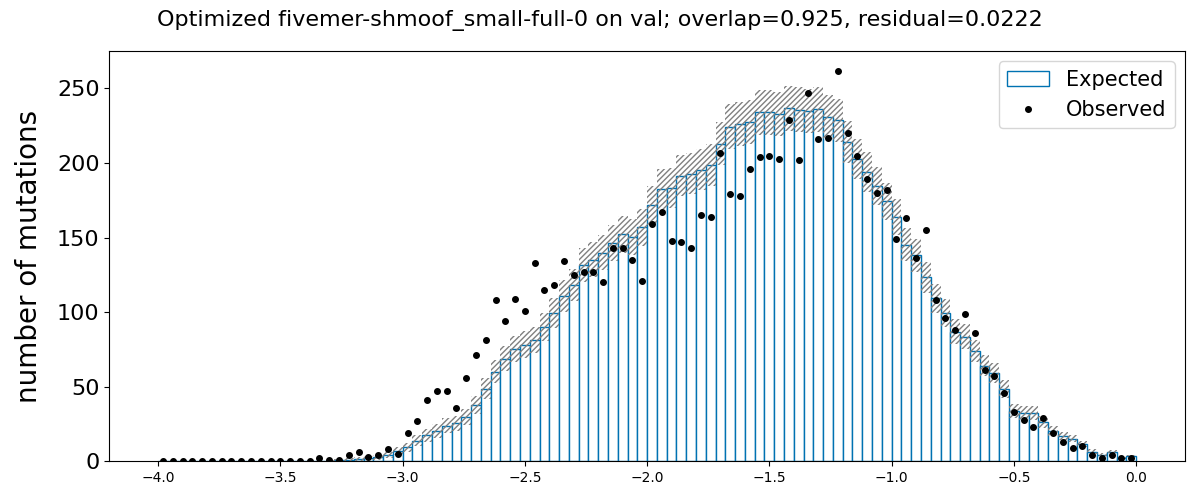

In [14]:
crepe_path = "../train/trained_models/fivemer-shmoof_small-full-0"
optimized_oe_plot(crepe_path, "val")

Finding optimal branch lengths: 100%|██████████| 2625/2625 [00:08<00:00, 319.37it/s]


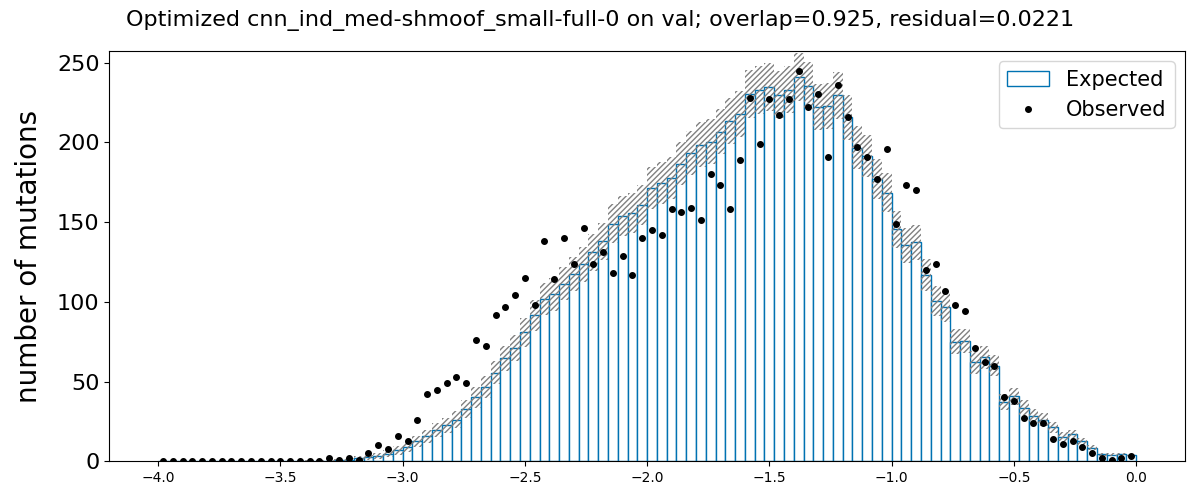

In [13]:
crepe_path = "../train/trained_models/cnn_ind_med-shmoof_small-full-0"
optimized_oe_plot(crepe_path, "val")

Finding optimal branch lengths: 100%|██████████| 5155/5155 [00:12<00:00, 403.30it/s]


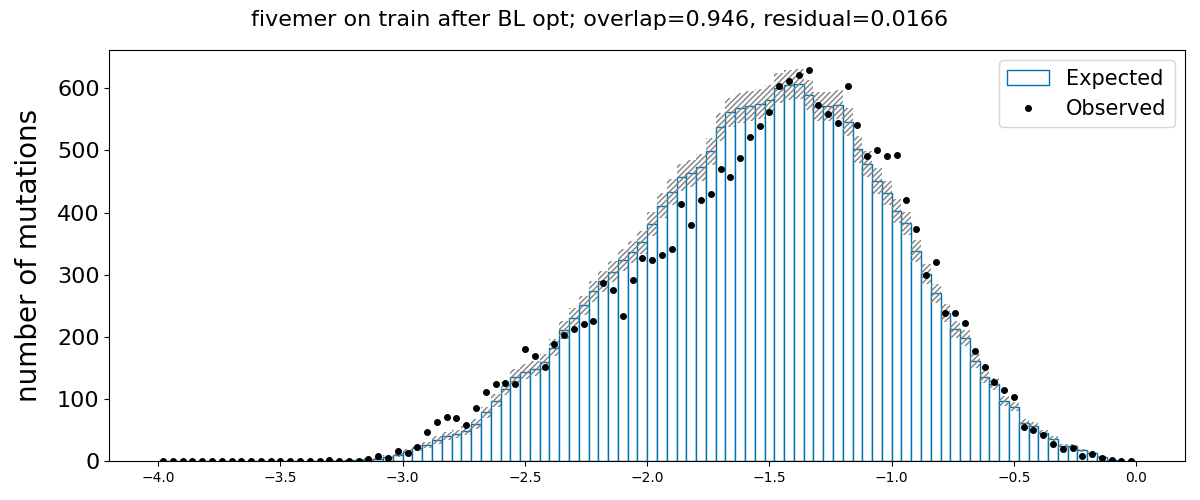

In [4]:
fivemer_crepe = framework.load_crepe("trained_models/fivemer")
optimized_bls = optimized_branch_lengths_of_crepe(fivemer_crepe, subsampled_train_df)
show_figure(oe_plot_of_crepe(fivemer_crepe, subsampled_train_df, optimized_bls, f"fivemer on train after BL opt")[0])

Finding optimal branch lengths: 100%|██████████| 5155/5155 [00:25<00:00, 204.77it/s]


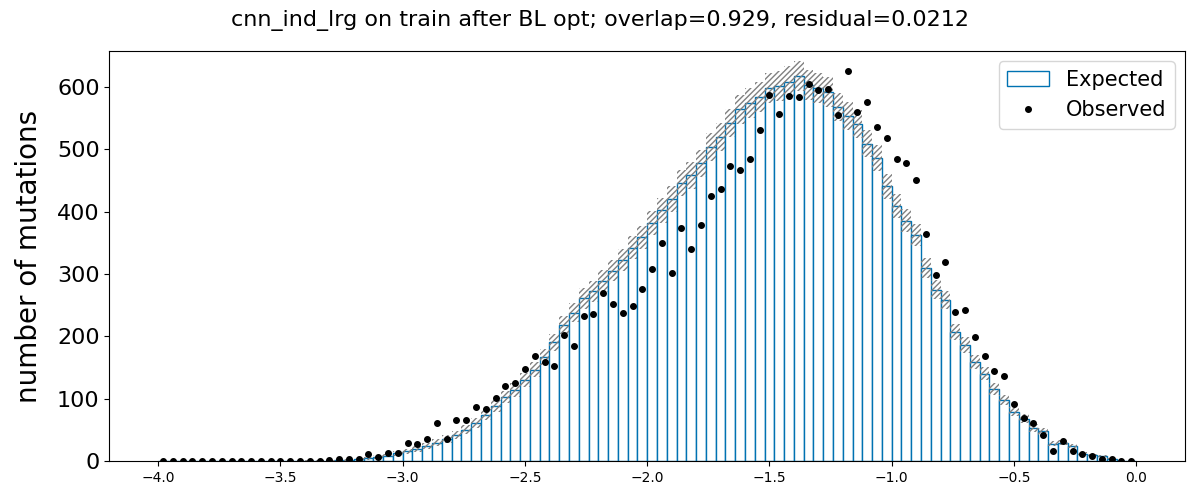

In [5]:
cnn_crepe = framework.load_crepe("trained_models/cnn_ind_lrg")
optimized_bls = optimized_branch_lengths_of_crepe(cnn_crepe, subsampled_train_df)
show_figure(oe_plot_of_crepe(cnn_crepe, subsampled_train_df, optimized_bls, f"cnn_ind_lrg on train after BL opt")[0])

In [7]:
crepe_path = "../train/trained_models/cnn_ind_med-shmoof_small-full-0"
model_name = crepe_path.split("/")[-1]
ermine_cnn_crepe = framework.load_crepe("../train/trained_models/cnn_ind_med-shmoof_small-full-0")

Finding optimal branch lengths: 100%|██████████| 5155/5155 [00:16<00:00, 304.59it/s]


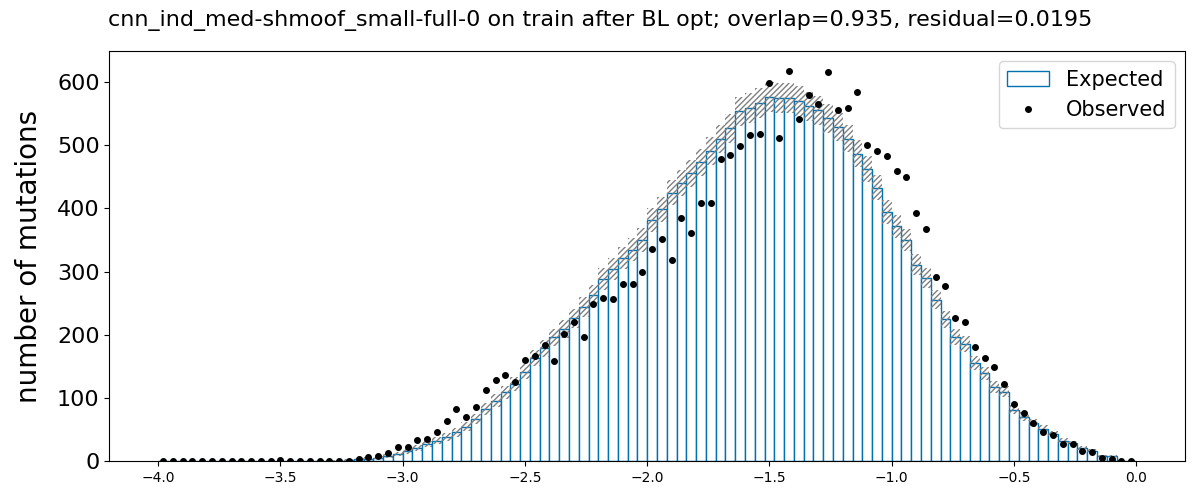

In [8]:
optimized_bls = optimized_branch_lengths_of_crepe(ermine_cnn_crepe, subsampled_train_df)
show_figure(oe_plot_of_crepe(ermine_cnn_crepe, subsampled_train_df, optimized_bls, f"{model_name} on train after BL opt")[0])

Finding optimal branch lengths: 100%|██████████| 2625/2625 [00:08<00:00, 316.90it/s]


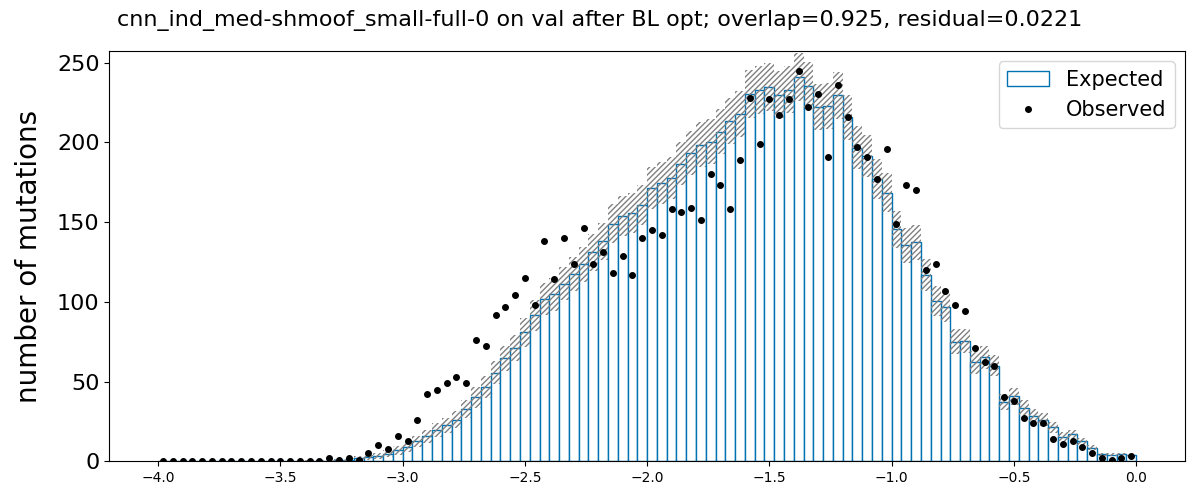

In [9]:
optimized_bls = optimized_branch_lengths_of_crepe(ermine_cnn_crepe, val_df)
show_figure(oe_plot_of_crepe(ermine_cnn_crepe, val_df, optimized_bls, f"{model_name} on val after BL opt")[0])